In [1]:
%load_ext autoreload
%autoreload 2

- **Date:** 2019-5-24  
- **Author:** Zhanyuan Zhang  
- **Purpose:** Naive patch attack

In [2]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
from bagnets.utils import pad_image, convert2channel_last, imagenet_preprocess, extract_patches, bagnet_predict, compare_heatmap
from bagnets.utils import class_patch_logits
from foolbox.utils import samples
import bagnets.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import time
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


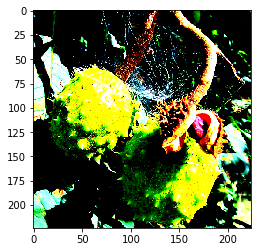

In [3]:
image, label = samples(dataset='imagenet', index=3, batchsize=1, shape=(224, 224), data_format='channels_first')

original_image = imagenet_preprocess(image[0])
plt.imshow(convert2channel_last(original_image))

In [4]:
def attack_patch(image, patchsize, num_patches, seed=None):
    c, x, y = image.shape
    if seed is not None:
        np.random.seed(seed)
    attacked_x = np.random.choice(range(x), size=num_patches, replace=True)
    attacked_y = np.random.choice(range(y), size=num_patches, replace=True)
    for xi, yi in zip(attacked_x, attacked_y):
        c, h, w = image[:, (xi - (patchsize-1)//2): (xi + (patchsize-1)//2), (yi - (patchsize-1) // 2): (yi + (patchsize-1) // 2)].shape
        image[:, (xi - (patchsize-1)//2): (xi + (patchsize-1)//2), (yi - (patchsize-1) // 2): (yi + (patchsize-1) // 2)] = np.random.rand(c, h, w)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


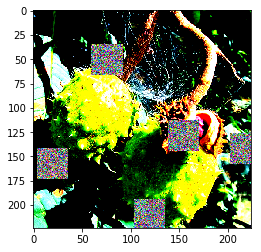

In [5]:
attacked_image = attack_patch(original_image.copy(), patchsize=33, num_patches=5, seed=789)
plt.imshow(convert2channel_last(attacked_image))